In [1]:
#Problem Statement:
#Identify which questions asked on Quora are duplicates of questions that have already been asked.

#This can be helpful for providing instant responses to questions that have already been addressed.

In [2]:
#Objective

#The goal of this project is to predict which of the provided pairs of questions contain two questions with the same meaning.

#Real World/Business Objectives and Constraints:
#The cost of a mis-classification can be very high.
#You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
#No strict latency concerns.
#Interpretability is partially important.

In [3]:
#About Dataset
#The dataset "Train.csv" contains 404,290 rowsand 5 columns

#Data fields
#id - the id of a training set question pair

#qid1, qid2 - unique ids of each question (only available in train.csv)

#question1, question2 - the full text of each question

#is_duplicate - is the dependent variable, and the target variable is set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import nltk
from collections import Counter 
import distance
from matplotlib import rcParams
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import sys
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.preprocessing import normalize
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import collections
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('C:\\Users\\admin\\Desktop\\innomatics Data Science\\Python\\train.csv')

In [6]:
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [7]:
print("Number of data points:",df.shape[0])


Number of data points: 404290


In [8]:
df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [10]:
# missing values
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [11]:
# duplicate rows
df.duplicated().sum()

0

In [12]:
#Checking if dataset is balanced or imbalanced

In [13]:
unique=len(set(list(df['qid1'])+list(df['qid2'])))
print ('Total number of  Unique Questions are: {}\n'.format(unique))

Total number of  Unique Questions are: 537933



In [14]:
#Percentage of Similar question and Non-Similar Question

In [15]:
print('-->> Question pairs are not Similar (is_duplicate = 0):\n     {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('-->> Question pairs are Similar (is_duplicate = 1):\n     {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

-->> Question pairs are not Similar (is_duplicate = 0):
     63.08%
-->> Question pairs are Similar (is_duplicate = 1):
     36.92%


In [16]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [17]:
preprocess("I've already! wasn't <b>done</b>?")


'i have already  was not done'

In [18]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

In [19]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0


In [20]:
df['q1_len'] = df['question1'].str.len() 
df['q2_len'] = df['question2'].str.len()

In [21]:
df['q1_num_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_num_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,50,87,12,17
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,49,58,12,16
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,75,38,15,7


In [22]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

In [23]:
df['word_common'] = df.apply(common_words, axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,11
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,50,87,12,17,8
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,4
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,49,58,12,16,1
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,75,38,15,7,4


In [24]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

In [25]:
df['word_total'] = df.apply(total_words, axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,11,23
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,50,87,12,17,8,26
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,4,24
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,49,58,12,16,1,22
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,75,38,15,7,4,21


In [26]:
df['word_share'] = round(df['word_common']/df['word_total'],2)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,11,23,0.48
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,50,87,12,17,8,26,0.31
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,4,24,0.17
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,49,58,12,16,1,22,0.05
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,75,38,15,7,4,21,0.19


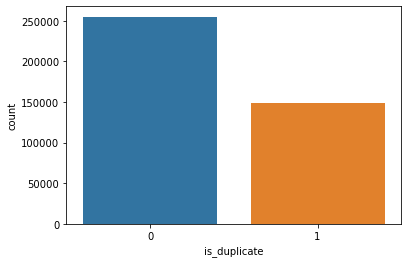

In [27]:
sns.countplot(df["is_duplicate"])
plt.show()

minimum characters 0
maximum characters 621
average num of characters 58


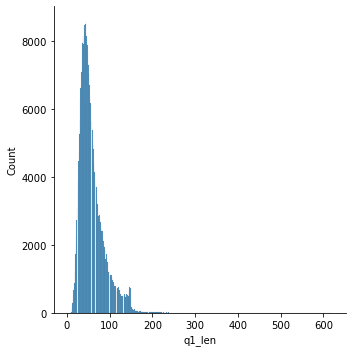

In [28]:
# Analysis of features
sns.displot(df['q1_len'])
print('minimum characters',df['q1_len'].min())
print('maximum characters',df['q1_len'].max())
print('average num of characters',int(df['q1_len'].mean()))

minimum characters 0
maximum characters 1170
average num of characters 59


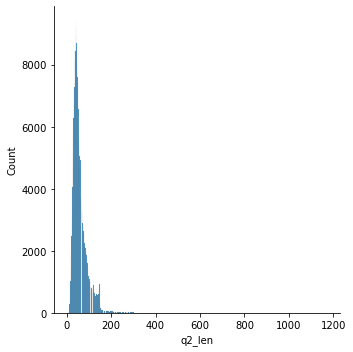

In [29]:
sns.displot(df['q2_len'])
print('minimum characters',df['q2_len'].min())
print('maximum characters',df['q2_len'].max())
print('average num of characters',int(df['q2_len'].mean()))

minimum words 1
maximum words 147
average num of words 11


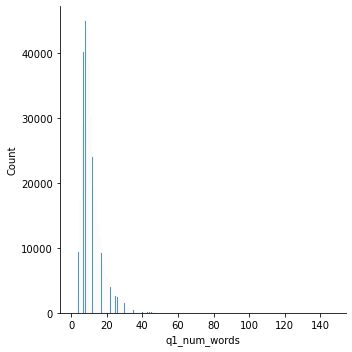

In [30]:
sns.displot(df['q1_num_words'])
print('minimum words',df['q1_num_words'].min())
print('maximum words',df['q1_num_words'].max())
print('average num of words',int(df['q1_num_words'].mean()))

minimum words 1
maximum words 270
average num of words 11


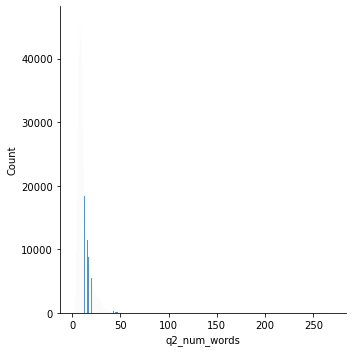

In [31]:
sns.displot(df['q2_num_words'])
print('minimum words',df['q2_num_words'].min())
print('maximum words',df['q2_num_words'].max())
print('average num of words',int(df['q2_num_words'].mean()))

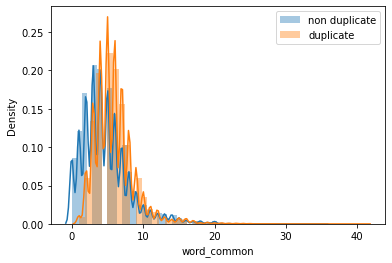

In [32]:
# common words
sns.distplot(df[df['is_duplicate'] == 0]['word_common'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['word_common'],label='duplicate')
plt.legend()
plt.show()


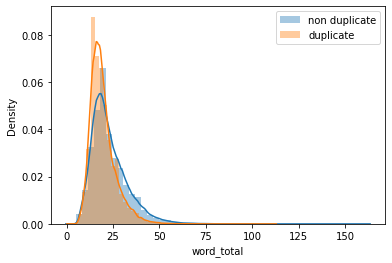

In [33]:
# total words
sns.distplot(df[df['is_duplicate'] == 0]['word_total'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['word_total'],label='duplicate')
plt.legend()
plt.show()

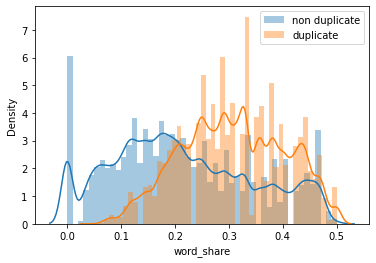

In [34]:
# word share
sns.distplot(df[df['is_duplicate'] == 0]['word_share'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['word_share'],label='duplicate')
plt.legend()
plt.show()

In [35]:
# Advanced Features
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [36]:
token_features =df.apply(fetch_token_features, axis=1)

df["cwc_min"]       = list(map(lambda x: x[0], token_features))
df["cwc_max"]       = list(map(lambda x: x[1], token_features))
df["csc_min"]       = list(map(lambda x: x[2], token_features))
df["csc_max"]       = list(map(lambda x: x[3], token_features))
df["ctc_min"]       = list(map(lambda x: x[4], token_features))
df["ctc_max"]       = list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [37]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,...,23,0.48,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,50,87,12,17,...,26,0.31,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,...,24,0.17,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,49,58,12,16,...,22,0.05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,75,38,15,7,...,21,0.19,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0


In [38]:
from random import randint
from wordcloud import WordCloud, STOPWORDS

In [39]:
# To customize colours of wordcloud texts
def wc_black_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(214, 67%%, %d%%)" % randint(60, 100)


# stopwords for wordcloud
def get_wc_stopwords():
    wc_stopwords = set(STOPWORDS)
    return wc_stopwords


# plot wordcloud
def plot_wordcloud(text, color_func):
    wc_stopwords = get_wc_stopwords()
    wc = WordCloud(stopwords=wc_stopwords, width=1200, height=600, random_state=0).generate(text)

    f, axs = plt.subplots(figsize=(10, 10))
    with sns.axes_style("ticks"):
        sns.despine(offset=10, trim=True)
        plt.imshow(wc.recolor(color_func=color_func, random_state=0), interpolation="bilinear")
        plt.xlabel('WordCloud')

Word Cloud for preprocesssed question1:


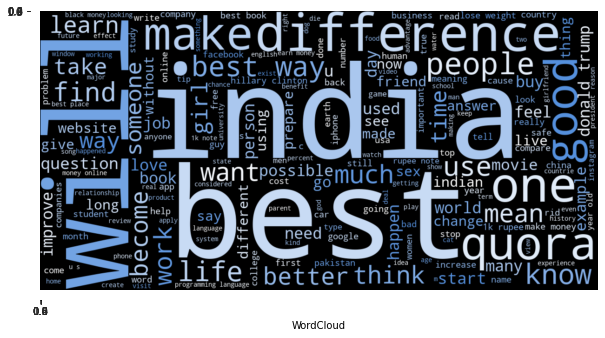

In [40]:
print("Word Cloud for preprocesssed question1:")
plot_wordcloud(' '.join(df.question1.values.tolist()), wc_black_color_func)

Word Cloud for preprocesssed question2:


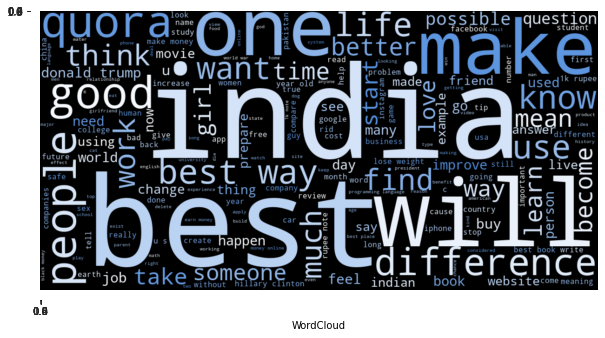

In [41]:
print("Word Cloud for preprocesssed question2:")
plot_wordcloud(' '.join(df.question2.values.tolist()), wc_black_color_func)

In [42]:
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [43]:

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    q1_token=[]
    q2_token=[]
    
    # Converting the Sentence into Tokens: 
    for i in range(0,len(q1)):
        a=q1[i].split()
        b=q2[i].split()
        q1_token.append(a)
        q2_token.append(b)
    
    if len(q1_token) == 0 or len(q2_token) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_token) - len(q2_token))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_token) + len(q2_token))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features